<ul><li>American Gut Project
</li><li>License: BSD
</li><li>Last Update: April 2014
</li></ul>

The following libraries will need to be installed
</li><li><a href="https://www.python.org/download/releases/2.7/">Python 2.7</a>
</li><li><a href="http://pycogent.org/">Pycogent 1.5.3</a>
</li><li><a href="http://picrust.github.io/picrust/install.html#install">PiCRUST</a>
</li><li><a href="http://biom-format.org/index.html">BIOM 1.3.1</a>
</li><li><a href="http://www.numpy.org/">Numpy 1.5.1</a>
</li><li><a href="http://www.scipy.org">SciPy</a>
</li><li><a href="http://pandas.pydata.org">pandas</a>
</li><li><a href="http://statsmodels.sourceforge.net/">statsmodels</a>
</li><li><a href="https://www.gnu.org/software/tar/">The tar utility</a>
</li></ul>

It is suggested to install these packages via pip and virtualenv (with the exception of python and picrust)

[Picrust](http://www.nature.com/nbt/journal/v31/n9/full/nbt.2676.html)
is a tool that estimates metagenome gene abundances just given 16S sequencing data.

This is done using phylogenetic infererence. Many of the bacteria mapped in the Greengenes database have full metagenomic profiles.  These metagenomic profiles are typically made up of gene annotations, annotated by [KEGG](http://www.oxfordjournals.org/our_journals/nar/database/summary/112), [COG](http://www.ncbi.nlm.nih.gov/COG/) or [RFAM](http://www.ncbi.nlm.nih.gov/pubmed/12520045). If a bacteria's 16S gene maps to one of the 16S genes in the Greengenes database, it has been shown that that bacteria will have also have a very similar metagenomic profile to the bacteria mapped in the Greengenes database.

In this tutorial, we using 16S genes to predict the KEGG proportions in the samples.

Note that this methodology is highly reliant on the integrity of the reference phylogenetic tree. Environments with poor bacterial reference genomes such as soil, will not yield meaningful predictions.

In this tutorial, we will be applying Picrust to the American Gut dataset to determine if there are significant differences between participants gut bacteria with respect to the number of types of plants consumed and 
the collection month that the sample was obtained.  This is used as a hypothesis deriving tool and cannot be used to 
make any conclusions - followup metagenomics surveys will need to be conducted to validate these hypotheses.

Assuming that all of the packages have been installed properly, we'll proceed to import all of the necessary libraries

In [233]:
import biom
from biom.parse import parse_biom_table
import numpy as np
import pandas as pd
import os, site
from scipy.stats.mstats import kruskalwallis
from statsmodels.sandbox.stats.multicomp import multipletests
from time import strftime, strptime
import matplotlib
import matplotlib.pyplot as plt

#from americangut.diversity_analysis import pretty_pandas_boxplot
%matplotlib inline
#matplotlib.rcParams['savefig.dpi'] = 2.5 * matplotlib.rcParams['savefig.dpi']

All of the data files should have been copied along with this tutorial in the github repository.

Assuming that all of the paths to these files haven't changed, we'll decompress the BIOM table.

In [6]:
!tar -zxvf ../data/AG/AG_100nt.zip -O > ../data/AG/AG_100nt.json

x AG_100nt.json


Before picrust can predict any of the metagenome profiles, it must first normalize by copy number.
Some bacterial species have significantly more 16S RNA genes than others.  Species with more 16S genes 
will be completely over-representing true genes proportions if not accounted for properly.

Now lets calculate copy numbers and predict metagenomes.  We do not want to rarefy because we are interested performing statistical calculations on the sample proportions

In [230]:
raw_file = "../data/AG/AG_100nt.json"
norm_file = "picrust/AG_100nt_norm.biom"
metagenomes_file = "picrust/AG_100nt_metagenomes.biom"
pathways_file = "picrust/AG_100nt_pathways.biom"

In [8]:
!mkdir picrust
!normalize_by_copy_number.py -i $raw_file -o $norm_file
!predict_metagenomes.py -i $norm_file -o $metagenomes_file

mkdir: picrust: File exists


In [231]:
!categorize_by_function.py -i $metagenomes_file -c KEGG_Pathways -l 3 -o $pathways_file

Read in all of the metadata and biom tables.

In [8]:
biom_table = parse_biom_table(open(metagenomes_file))

In [9]:
metadata = pd.read_table("../data/AG/AG_100nt.txt", index_col=0, low_memory=False, na_values=['no_data', 'unknown'])

Now, lets convert all of our data into a pandas dataframe to simplify data manipulation

In [10]:
df = pd.DataFrame()
for samp_v, samp_id, samp_md in biom_table.iterSamples():
    df[samp_id] = pd.Series(samp_v, index = biom_table.ObservationIds)
df = df.transpose()

Let's first filter out some of the rare observed genes

In [203]:
# Filter out KOs with less than 1000 estimated genes
table = df.loc[:, df.sum(axis=0) > 1000]

Now let's only consider the heathly subset - using same functionality in Alpha Diversity notebooks.

In [204]:
# Defines the filtering functions for alpha diversity
subset_f = {'AGE': lambda x: 19 < x and not np.isnan(x),          
            'DIABETES': lambda x: x == 'I do not have diabetes',
            'IBD': lambda x: x == 'I do not have IBD',
            'ANTIBIOTIC_SELECT': lambda x: x == 'Not in the last year',
            'BMI': lambda x: 18.5 <= x < 30 and not np.isnan(x)}

# Determines which samples meet the requirements of the categories
new_bin = {}
for cat, f in subset_f.iteritems():
    new_bin[cat] = metadata[cat].apply(f)

# Builds up the new binary dataframe
bin_frame = pd.DataFrame(new_bin)

# Adds a column to the current dataframe to look at the subset
bin_series = pd.DataFrame(new_bin).all(1)

# Filters the original mapping file so only samples which satisfy the criteria are included in the new metadata file.
metadata = metadata.groupby(bin_series).get_group(True)

And trim out all samples in table not in metadata and normalize the data so that all of the OTU abundances for each sample adds up to 1.

In [205]:
# Trim out samples not in metadata
table = table.loc[metadata.index]
# Normalize all gene counts
table = table.div(table.sum(axis=1), axis=0)

Let's implement the krustal-wallis test.  This test will be flexible so that we can test to see if the gene abundances
can be used to identify difference between metadata categories.  We'll demonstrate this use in a bit.

In [206]:
def kw_test(table, metadata, cat, alpha=0.05):
    """
    Performs a krustal wallis test on all of the genes with respect to metadata groups
    
    Parameters
    ----------
    table : pandas.DataFrame
        contingency table containing genes proportions for each sample where
        rows = samples
        columns = gene ids
    metadata : pandas.DataFrame
        contingency table containing metadata information about each sample where
        rows = samples
        columns = metadata field (e.g. ZIP code)
    cat : string
        metadata category.  This will be used to specify the columns in the metadata
        
    Returns
    -------
    accepted_keggs : list, tuple
        A list of tuples.  Each tuple contains information about
        1. kegg id : str
           Kegg identifier
        2. pvalue : float
           Type I error of accepting that kegg is a differientiating kegg
        3. reject : bool
           Reject if kegg pvalue has a p value less than 5%
    """
    group_indeces = metadata.groupby(cat).groups.values()
    f = lambda x: kruskalwallis(*[x.loc[i] for i in group_indeces])
    results = table.apply(f, axis=0)
    # Don't forget about multiple comparison testing
    reject, pvalues, _, _ = multipletests(zip(*results.values)[1], alpha=alpha)
    keggs = zip(table.columns, pvalues, reject)
    accepted_keggs=filter(lambda x: x[2]==True, keggs)
    # Sort ascending with respect to p-value
    accepted_keggs=sorted(accepted_keggs, key=lambda x: x[1])
    return accepted_keggs

Now, apply Krustal-Wallis to test for group signficances between types of plants consumed for each individual over
the time scale of a month

In [15]:
accepted_plant_keggs = kw_test(table, metadata, "TYPES_OF_PLANTS")
accepted_plant_keggs

[(u'K03483', 0.043919213648777156, True)]

Before producing the box plot, we'll want to create a separate dataframe and remove some of the NaNs.

In [207]:
def subset_dataframe(table, metadata, keggs, cat):
    """
    Returns a subset whose columns are specified by the gene names.
    Also removes all samples with a null value for the metadata category
    
    Parameters
    ----------
    table : pandas.DataFrame
        contingency table containing genes proportions for each sample where
        rows = samples
        columns = gene ids
    metadata : pandas.DataFrame
        contingency table containing metadata information about each sample where
        rows = samples
        columns = metadata field (e.g. ZIP code)
    keggs : str
        The gene in the table that will be copied over to a new pandas DataFrame
        for plotting
    cat : string
        metadata category.  This will be used to specify the columns in the metadata
        
    Returns
    -------
    pandas.DataFrame
    """
    df = pd.DataFrame(index=table.index)
    df[keggs] = table[keggs]
    df[cat] = metadata[cat]
    df = df[pd.notnull(metadata[cat])]
    #df = df[pd.notnull(df[keggs])]
    return df

In [208]:
plant_kegg = accepted_plant_keggs[0][0]
plant_df = subset_dataframe(table=table,
                            metadata=metadata, 
                            keggs=plant_kegg, 
                            cat="TYPES_OF_PLANTS")

Now let's plot the boxplots for the only signficant kegg associated with types of plants identified.

(3.162277660168379e-06, 0.0031622776601683794)

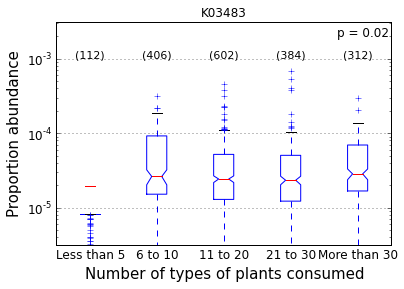

In [235]:
num_plant_types = ['Less than 5', '6 to 10', '11 to 20', '21 to 30', 'More than 30']
a_fig = pretty_pandas_boxplot(meta=plant_df,
                              group='TYPES_OF_PLANTS',
                              cat=plant_kegg,
                              order=num_plant_types,
                              n_y=10**-3,  # specify plot position of sample group counts
                              p_y=10**-2.7 # specify plot position of krustal-wallis p-value
                             )
plt.title(plant_kegg)
plt.xlabel('Number of types of plants consumed')
plt.ylabel('Proportion abundance')
plt.yscale('log')
plt.ylim([10**-5.5, 10**-2.5])

Apparently, [K03483](http://www.genome.jp/dbget-bin/www_bget?ko:K03483) is a transcriptional antiterminator, which fixes pretermination of RNA transcription complex during transcription.

Now, let's investigate how predicted gene abundances vary with collection month.  First, let's bin the ages into decades, before running the krustal wallis test

In [210]:
# Sets up the category parameters
category = 'COLLECTION_MONTH'
base_cat = 'COLLECTION_DATE'

# Sets a function to convert the collection date, if necessary
def get_month(date_str):
    """converts a date to a month string"""
    if len(date_str) > 8:
        return strftime('%B', strptime(date_str, '%m/%d/%Y'))
    else:
        return strftime('%B', strptime(date_str, '%m/%d/%y'))
# Converts the collection date
if category not in metadata.columns:
    metadata[category]= metadata[base_cat].apply(get_month)

In [219]:
accepted_month_keggs = kw_test(table, metadata, "COLLECTION_MONTH",alpha=10**-7)
accepted_month_keggs

[(u'K05844', 0.0, True),
 (u'K00508', 0.0, True),
 (u'K05596', 0.0, True),
 (u'K01828', 0.0, True),
 (u'K03647', 0.0, True),
 (u'K12428', 0.0, True),
 (u'K08994', 0.0, True),
 (u'K02475', 0.0, True),
 (u'K02476', 0.0, True),
 (u'K09019', 0.0, True),
 (u'K13927', 0.0, True),
 (u'K00758', 0.0, True),
 (u'K07156', 0.0, True),
 (u'K05365', 0.0, True),
 (u'K06945', 0.0, True),
 (u'K10805', 0.0, True),
 (u'K05564', 0.0, True),
 (u'K05560', 0.0, True),
 (u'K04766', 0.0, True),
 (u'K04768', 0.0, True),
 (u'K09681', 0.0, True),
 (u'K00301', 0.0, True),
 (u'K13693', 0.0, True),
 (u'K05977', 0.0, True),
 (u'K07110', 0.0, True),
 (u'K07113', 0.0, True),
 (u'K07119', 0.0, True),
 (u'K03919', 0.0, True),
 (u'K02351', 0.0, True),
 (u'K13573', 0.0, True),
 (u'K13572', 0.0, True),
 (u'K10843', 0.0, True),
 (u'K01720', 0.0, True),
 (u'K03761', 0.0, True),
 (u'K12583', 0.0, True),
 (u'K07465', 0.0, True),
 (u'K10674', 0.0, True),
 (u'K10240', 0.0, True),
 (u'K10241', 0.0, True),
 (u'K02616', 0.0, True),


Now, there are a TON of significant keggs associated with the collection month.  So we'll plot all of these signficiant KEGGs in a heatmap.

In [220]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 
               'December']
month_keggs = [k[0] for k in accepted_month_keggs]
month_df = subset_dataframe(table=table, 
                            metadata=metadata, 
                            keggs=month_keggs, 
                            cat="COLLECTION_MONTH")

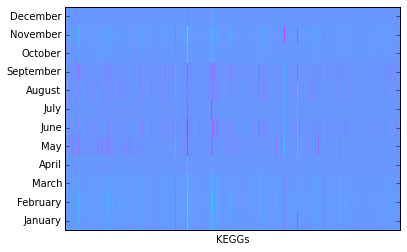

In [234]:
fig, ax = plt.subplots()

month_tables = month_df.groupby("COLLECTION_MONTH")
means = month_tables.aggregate(np.mean)
month_means = means.reindex(month_names)
# Center each KEGG around its mean
M = month_means.apply(lambda x: x - np.mean(x),axis=0).as_matrix()
ax.pcolor(M, cmap=matplotlib.cm.cool)
ax.set_yticks(np.arange(month_means.shape[0])+0.5, minor=False)
ax.set_yticklabels(month_names, minor=False)
#plt.colorbar()
plt.xlabel('KEGGs')
plt.xlim([0,month_means.shape[1]])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

Let's repeat this analysis with the pathway information

In [236]:
biom_table = parse_biom_table(open(pathways_file))
df = pd.DataFrame()
for samp_v, samp_id, samp_md in biom_table.iterSamples():
    df[samp_id] = pd.Series(samp_v, index = biom_table.ObservationIds)
df = df.transpose()
# Filter out pathways with less than 1000 estimated genes
pwys = df.loc[:, df.sum(axis=0) > 1000]
# Trim out samples not in metadata
pwys = pwys.loc[metadata.index]
# Normalize all gene counts
pwys = pwys.div(table.sum(axis=1), axis=0)

In [240]:
accepted_month_pwys = kw_test(pwys, metadata, "COLLECTION_MONTH",alpha=10**-7)
accepted_month_pwys

[(u'Bacterial invasion of epithelial cells', 0.0, True),
 (u'Bladder cancer', 0.0, True),
 (u'Hypertrophic cardiomyopathy (HCM)', 0.0, True),
 (u'Isoflavonoid biosynthesis', 0.0, True),
 (u'Cytochrome P450', 5.3211879347259128e-12, True),
 (u'Bile secretion', 1.1716627668079127e-11, True),
 (u'Biosynthesis of type II polyketide products',
  2.6009194797893542e-11,
  True),
 (u'African trypanosomiasis', 2.1093793378668124e-10, True),
 (u'alpha-Linolenic acid metabolism', 3.5415848032016584e-10, True),
 (u'Basal transcription factors', 9.6592334131173629e-10, True),
 (u'Calcium signaling pathway', 2.3093152945463657e-09, True),
 (u'Chagas disease (American trypanosomiasis)', 3.6333913655539618e-09, True),
 (u'Renin-angiotensin system', 4.9469288665449085e-09, True),
 (u'Metabolism of xenobiotics by cytochrome P450',
  6.9069758801276748e-09,
  True),
 (u'Drug metabolism - cytochrome P450', 2.0579534298903468e-08, True),
 (u'Biosynthesis of type II polyketide backbone',
  7.57663729533675

In [241]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 
               'December']
month_pwys = [k[0] for k in accepted_month_pwys]
month_df = subset_dataframe(table=pwys,
                            metadata=metadata, 
                            keggs=month_pwys, 
                            cat="COLLECTION_MONTH")

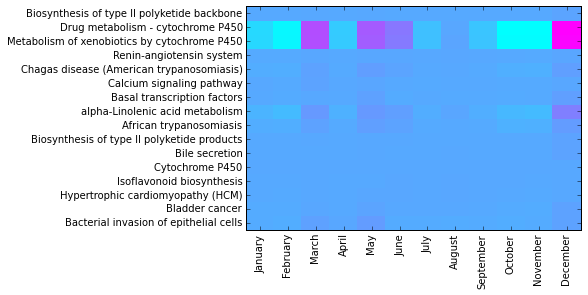

In [270]:
fig, ax = plt.subplots()

month_tables = month_df.groupby("COLLECTION_MONTH")
means = month_tables.aggregate(np.mean)
month_means = means.reindex(month_names)
# Center each pathway around its mean
M = month_means.apply(lambda x: x - np.mean(x),axis=0).as_matrix().T
ax.pcolor(M, cmap=matplotlib.cm.cool)
ax.set_yticks(np.arange(month_means.shape[1])+0.5, minor=False)
ax.set_yticklabels(month_pwys)
ax.set_xticks(np.arange(month_means.shape[0])+0.5, minor=False)
ax.set_xticklabels(month_names, minor=False, rotation=90)
plt.ylim([0,month_means.shape[1]])
fig.savefig('month_pathways.pdf', pad_inches=3)